<a href="https://colab.research.google.com/github/Zia-Ul-Hasan/Churn-Prediction-IBM-telco/blob/main/binary%20predict_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Load the dataset
path = 'Telco_customer_churn.xlsx'
df = pd.read_excel(path)
def replace_t(df):
    df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)
    return df

df = replace_t(df)

# Convert data types
df['Monthly Charges'] = df['Monthly Charges'].astype(float)
df['CLTV'] = df['CLTV'].astype(float)
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Tenure Months'] = pd.to_numeric(df['Tenure Months'], errors='coerce')
df['Churn Value'] = pd.to_numeric(df['Churn Value'], errors='coerce')
# Dropping unnecessary columns
df = df.drop(['CustomerID', 'Country', 'Count', 'State', 'Zip Code', 'Lat Long', 'Longitude', 'Latitude', 'Churn Score', 'Churn Label','Churn Reason'], axis=1)
# Remove rows with missing Total Charges
df = df.dropna(subset=['Total Charges'])
print(df.isnull().sum())
print(df.dtypes)

City                 0
Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Value          0
CLTV                 0
dtype: int64
City                  object
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing

City                 7032
Gender               7032
Senior Citizen       7032
Partner              7032
Dependents           7032
Tenure Months        7032
Phone Service        7032
Multiple Lines       7032
Internet Service     7032
Online Security      7032
Online Backup        7032
Device Protection    7032
Tech Support         7032
Streaming TV         7032
Streaming Movies     7032
Contract             7032
Paperless Billing    7032
Payment Method       7032
Monthly Charges      7032
Total Charges        7032
Churn Value          7032
CLTV                 7032
dtype: int64
       Tenure Months  Monthly Charges  Total Charges  Churn Value         CLTV
count    7032.000000      7032.000000    7032.000000  7032.000000  7032.000000
mean       32.421786        64.798208    2283.300441     0.265785  4401.445108
std        24.545260        30.085974    2266.771362     0.441782  1182.414266
min         1.000000        18.250000      18.800000     0.000000  2003.000000
25%         9.000000

'\nfor ele in numm_col:\n  q1=ele.percentile(25)\n  q3=ele.percentile(75)\n  iqr= q3-q1\n  UL = q3+(1.5*iqr)\n  LL = q1-(1.5*iqr)\n  for sub_ele in ele:\n    if (sub_ele > LL) || (sub_ele > UL):\n'

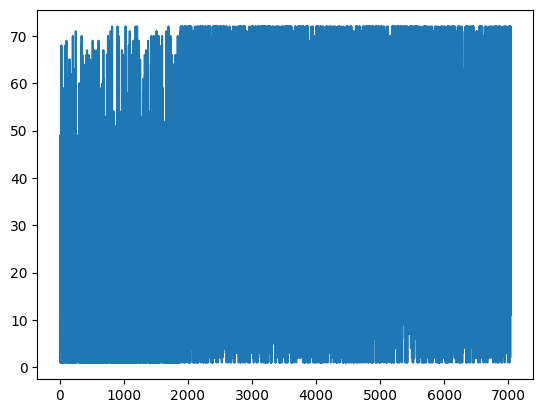

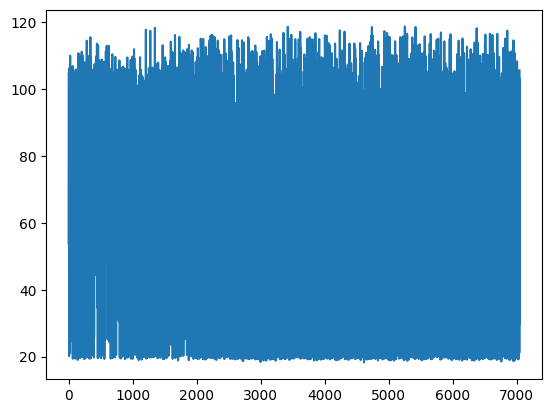

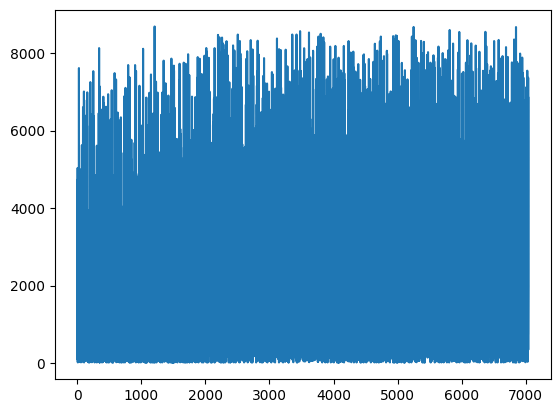

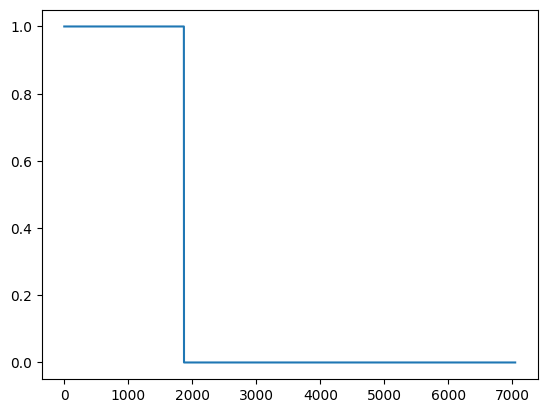

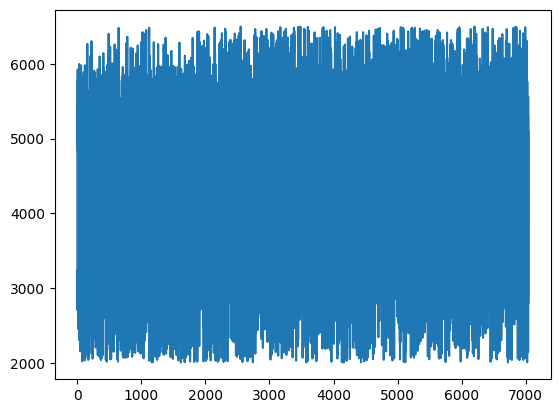

In [31]:
print(df.count())
#outlier detection
numm_col=[]
for element in df.columns:
    if pd.api.types.is_numeric_dtype(df[element]):
        numm_col.append(element)
        plt.figure()
        plt.plot(df[element])

print(df.describe()[numm_col])

'''
for ele in numm_col:
  q1=ele.percentile(25)
  q3=ele.percentile(75)
  iqr= q3-q1
  UL = q3+(1.5*iqr)
  LL = q1-(1.5*iqr)
  for sub_ele in ele:
    if (sub_ele > LL) || (sub_ele > UL):
'''


In [32]:
#variable encoding
x =df.drop('Churn Value',axis =1)
y= df['Churn Value']
pd.DataFrame(y)

num_col = []
LE_col = ['City']
OE_col = []
for col in x.columns:
    if pd.api.types.is_numeric_dtype(x[col]):
        num_col.append(col)
    else :
        OE_col.append(col)

#only city feature would be label encoded due to hight number of uniques values // it non ordinal
OE_col.remove('City')

# One-hot encoding function
def one_hot_encode_columns(df, columns):
    for column in columns:
        one_hot = pd.get_dummies(df[column], prefix=column)
        df = df.drop(column, axis=1)
        df = pd.concat([df, one_hot], axis=1)
    return df

# Label encoding function
LE = LabelEncoder()
def label_encode_columns(df, columns):
    for col in columns:
        df[col] = LE.fit_transform(df[col])
    return df

x= one_hot_encode_columns(x, OE_col)
x= label_encode_columns(x, LE_col)
print (x.dtypes)



#standardizing values
scaler = StandardScaler()
x[num_col] = scaler.fit_transform(x[num_col])


City                                          int64
Tenure Months                                 int64
Monthly Charges                             float64
Total Charges                               float64
CLTV                                        float64
Gender_Female                                  bool
Gender_Male                                    bool
Senior Citizen_No                              bool
Senior Citizen_Yes                             bool
Partner_No                                     bool
Partner_Yes                                    bool
Dependents_No                                  bool
Dependents_Yes                                 bool
Phone Service_No                               bool
Phone Service_Yes                              bool
Multiple Lines_No                              bool
Multiple Lines_Yes                             bool
Internet Service_DSL                           bool
Internet Service_Fiber optic                   bool
Internet Ser

In [ ]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(x, y)

# Creating a Series for feature importances
feat_importances = pd.Series(importances, index=x.columns)

# Sorting the feature importances for better readability
feat_importances = feat_importances.sort_values(ascending=True)

# Printing the feature importances
for feature, importance in feat_importances.items():
    print(f"Feature: {feature}, Information Gain: {importance:.4f}")
    # List of features to drop
features_to_drop = [
    'Streaming TV_Yes', 'Multiple Lines_No', 'Streaming Movies_Yes', 'Streaming Movies_No',
    'CLTV', 'Phone Service_No', 'Gender_Male', 'Streaming TV_No'
]

# Dropping the irrelevant features
x_reduced = x.drop(columns=features_to_drop)
# Create a DataFrame for feature importances
feat_importances = pd.Series(importances, index=x.columns)

# Selecting features with information gain above a threshold
threshold = 0.01
selected_features = feat_importances[feat_importances > threshold].index.tolist()

# Subset the data with selected features
x_selected = x[selected_features]

print(f"Selected features: {selected_features}")

Feature: Device Protection_No, Information Gain: 0.0000
Feature: Multiple Lines_Yes, Information Gain: 0.0000
Feature: Gender_Female, Information Gain: 0.0000
Feature: Streaming Movies_No, Information Gain: 0.0000
Feature: Phone Service_No, Information Gain: 0.0010
Feature: CLTV, Information Gain: 0.0010
Feature: Payment Method_Bank transfer (automatic), Information Gain: 0.0015
Feature: Online Backup_Yes, Information Gain: 0.0024
Feature: Multiple Lines_No, Information Gain: 0.0033
Feature: Streaming TV_No, Information Gain: 0.0035
Feature: Streaming Movies_Yes, Information Gain: 0.0041
Feature: Phone Service_Yes, Information Gain: 0.0059
Feature: Internet Service_DSL, Information Gain: 0.0069
Feature: City, Information Gain: 0.0078
Feature: Streaming TV_Yes, Information Gain: 0.0081
Feature: Payment Method_Credit card (automatic), Information Gain: 0.0093
Feature: Online Backup_No, Information Gain: 0.0103
Feature: Partner_No, Information Gain: 0.0104
Feature: Online Security_Yes, In

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_selected, y, test_size=0.2, random_state=42)

# Training a RandomForest classifier
model = RandomForestClassifier(random_state=42)
model.fit(x_train, y_train)

# Making predictions
y_pred = model.predict(x_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7854
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1012
           1       0.65      0.51      0.57       395

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.79      0.78      1407

